# Настройки и импорты

In [ ]:
import warnings # Модуль для управления предупреждениями
import pickle # Модуль для сериализации и десериализации объектов Python
import numpy as np # Библиотека для работы с массивами и математическими операциями
import matplotlib.pyplot as plt # Библиотека для визуализации данных
import seaborn as sns # Библиотека для визуализации статистических данных
import string # Библиотека для работы со строками

from tensorflow.keras import utils # Утилиты для работы с данными в Keras
from tensorflow.keras.models import Sequential # Модель Sequential для построения нейронных сетей
from tensorflow.keras.layers import Dense, Flatten # Слои Dense и Flatten для нейронных сетей
from tensorflow.keras.layers import Conv2D, MaxPooling2D # Слои Conv2D и MaxPooling2D для сверточных нейронных сетей
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint # Обратные вызовы для управления обучением модели в Keras
from tensorflow.keras.optimizers import Adam # Оптимизатор Adam для обучения нейронных сетей

from sklearn.model_selection import train_test_split # Модуль для разделения данных на обучающие и тестовые наборы
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score # Функции для вычисления метрик оценки модели

In [2]:
# Отключение вывода предупреждений
warnings.filterwarnings('ignore')

# Загрузка данных

Используя библиотеку `pickle`, загрузим данные из файлов формата `pickle`, которые хранят объекты `Python` в сериализованной форме. Сериализация представляет собой процесс преобразования структуры данных или объекта в форму, которая может быть легко сохранена или передана через сеть и восстановлена обратно в исходную структуру данных или объект.

In [3]:
with open('/kaggle/input/symbols-on-russian-license-plates/X.pickle', 'rb') as f:
    X_train_org = pickle.load(f)
    
with open('/kaggle/input/symbols-on-russian-license-plates/Y.pickle', 'rb') as f:
    Y_train_org = pickle.load(f)

Реализуем функцию `plot_samples` для визуализации образцов изображений для каждого символа из заданного набора данных.

In [4]:
def plot_samples(X, Y, num_samples=7, figsize=(10, 10)):
    
    """
    Функция для визуализации образцов изображений символов.

    Аргументы:
    X (array): Массив изображений.
    Y (array): Массив меток соответствующих изображений.
    num_samples (int): Количество образцов для отображения каждого символа (по умолчанию 7).
    figsize (tuple): Размеры результирующего изображения (по умолчанию (10, 10)).

    Возвращает:
    None
    """

    # Определение списка символов (цифры и буквы)
    digits = string.digits
    letters = "ABEKMHOPCTYX"
    symbols = digits + letters

    # Создание сетки изображений для визуализации
    fig, axes = plt.subplots(num_samples, len(symbols), figsize=figsize)

    # Перебор всех символов
    for y, cls in enumerate(symbols):
        # Получение индексов изображений для каждого класса символа
        if cls in digits:
            class_idxs = np.where(Y == cls)[0]
        else:
            class_idxs = np.where(Y == cls)[0]
            
        # Ограничение количества изображений для отображения
        if len(class_idxs) > num_samples:
            class_idxs = np.random.choice(class_idxs, num_samples, replace=False)
            
        # Отображение образцов изображений символов
        for i, idx in enumerate(class_idxs):
            axes[i, y].imshow(X[idx], cmap='gray')
            axes[i, y].axis('off')
            # Установка заголовка только для первого изображения каждого символа
            if i == 0:
                axes[i, y].set_title(cls)

    # Отображение сетки изображений
    plt.show()


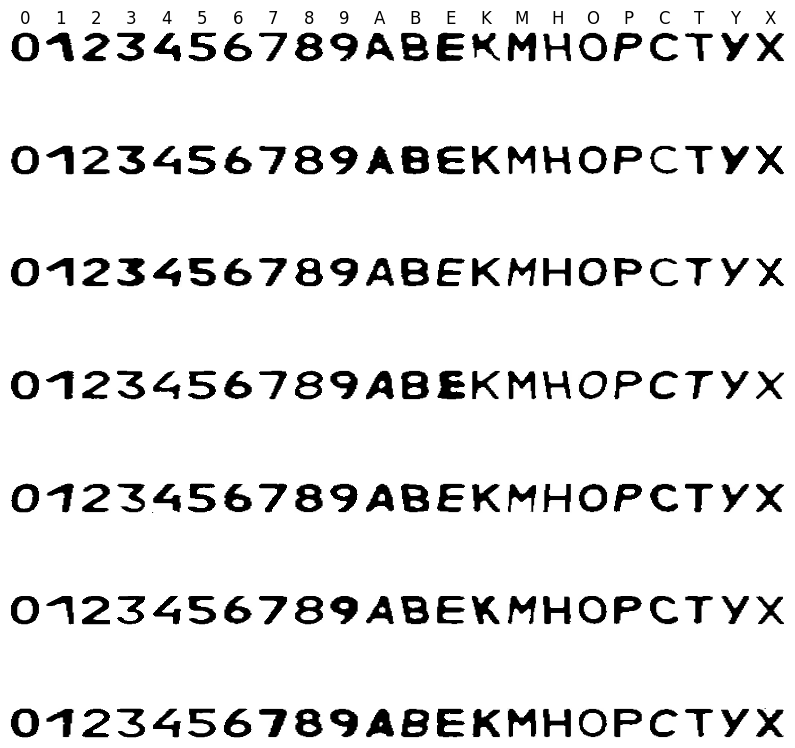

In [5]:
plot_samples(X_train_org, Y_train_org)

Зададим некоторые константы, которые понадобятся нам в дальнейшем для создания и обучения сверточной нейронной сети.

In [6]:
# Количество уникальных классов (символов) в наборе данных
NUM_CLASSES = 22
# Количество каналов цветности изображений (в данном случае - черно-белые изображения, поэтому 1 канал)
NUM_CHANNELS = 1
# Ширина изображений в пикселях
WIDTH = 30
# Высота изображений в пикселях
HEIGHT = 30
# Случайное начальное значение для генерации случайных чисел
RANDOM_STATE = 42

# Обработка данных

Разделим выборку на тренировочную и валидационную части. Выполним стратификацию по таргетам, чтобы в двух выборках была одинаковая доля классов, без дисбаланса, иначе это может повлиять на качество работы сети.

In [7]:
X_train, X_val, Y_train, Y_val = train_test_split(X_train_org,
                                                  Y_train_org,
                                                  test_size=0.2,
                                                  stratify=Y_train_org,
                                                  random_state=RANDOM_STATE)

Создадим словарь для кодирования классов. Этот словарь представляет собой набор соответствий между символами (классами) и их числовыми представлениями. Такое представление классов необходимо для работы с моделями машинного обучения, которые ожидают числовые метки классов.

In [8]:
label_mapping = {
    '0': 0,
    '1': 1,
    '2': 2,
    '3': 3,
    '4': 4,
    '5': 5,
    '6': 6,
    '7': 7,
    '8': 8,
    '9': 9,
    'A': 10,
    'B': 11,
    'E': 12,
    'K': 13,
    'M': 14,
    'H': 15,
    'O': 16,
    'P': 17,
    'C': 18,
    'T': 19,
    'Y': 20,
    'X': 21
}

Выполним преобразование текстовых меток в числовой формат и применим к ним `one-hot encoding`, чтобы метки стали векторами, где количество элементов в векторе — это количество классов, и 1 в векторе соответствует принадлежности к опреденному классу.

In [9]:
# Преобразование текстовых меток в числовой формат
mapping_function = np.vectorize(lambda label: label_mapping[label])
Y_train = mapping_function(Y_train)
Y_val = mapping_function(Y_val)

# Применение one-hot encoding к числовым меткам
Y_train = utils.to_categorical(Y_train, NUM_CLASSES)
Y_val = utils.to_categorical(Y_val, NUM_CLASSES)

Посмотрим размерности массивов с метками классов после преобразования.

In [10]:
print(f'Тренировочная часть: {Y_train.shape}')
print(f'Валидационная часть: {Y_val.shape}')

Тренировочная часть: (528, 22)
Валидационная часть: (132, 22)


Добавим дополнительную размерность массиву с изображениями, поскольку модель нейронной сети может работать только с трехмерными массивами, где третья размерность — количество цветовых каналов. В нашем случае канал один — оттенки серого.

In [11]:
X_train = np.expand_dims(X_train, axis=3)
X_val = np.expand_dims(X_val, axis=3)

Посмотрим размерности массивов с изображениями после преобразования.

In [12]:
print(f'Дополнительная размерность тренировочной выборки: {X_train.shape}')
print(f'Дополнительная размерность валидационной выборки: {X_val.shape}')

Дополнительная размерность тренировочной выборки: (528, 30, 30, 1)
Дополнительная размерность валидационной выборки: (132, 30, 30, 1)


# Построение модели нейронной сети

Создадим нейросетевую модель с использованием библиотеки `Keras` с помощью `Sequential API`.

In [13]:
model = Sequential([
    # Сверточный слой Conv2D
    Conv2D(filters=8, kernel_size=3, input_shape=(WIDTH, HEIGHT, NUM_CHANNELS)),
    # Слой MaxPooling2D
    MaxPooling2D(pool_size=2, strides=2),
    # Полносвязный слой Flatten
    Flatten(),
    # Полносвязный слой Dense с функцией активации ReLU
    Dense(units=32, activation='relu'),
    # Выходной слой Dense с функцией активации softmax (для задачи классификации)
    Dense(units=NUM_CLASSES, activation='softmax')
])

### Описание слоев нейросетевой модели:

**Conv2D (сверточный слой)**:
   - `filters=8`: Определяет количество фильтров (ядер) в сверточном слое, что также соответствует количеству выходных каналов.
   - `kernel_size=3`: Размер ядра свертки. Здесь используется ядро размером 3x3.
   - `input_shape=(WIDTH, HEIGHT, NUM_CHANNELS)`: Форма входных данных для первого сверточного слоя.

**MaxPooling2D (слой подвыборки):**
   - `pool_size=2`: Определяет размер окна подвыборки для уменьшения размерности данных.
   - `strides=2`: Определяет шаг окна подвыборки.

**Flatten (выравнивающий слой):**
   - Преобразует данные в одномерный массив для передачи их в полносвязный слой.

**Dense (полносвязный слой):**
   - `units=32`: Количество нейронов в слое. Этот слой представляет собой полносвязный слой с 32 нейронами.
   - `activation='relu'`: Функция активации ReLU добавляет нелинейность в сеть.

**Dense output (выходной слой):**
   - `units=NUM_CLASSES`: Количество нейронов в выходном слое соответствует количеству классов в задаче классификации.
   - `activation='softmax'`: Функция активации `softmax используется для задач многоклассовой классификации, преобразуя выходные значения в вероятности принадлежности к каждому классу.
   Функция активации softmax имеет вид $$Softmax(x_{i}) = \frac{exp(x_i)}{\sum_{j} exp(x_{j})}$$

Скомпилируем нейросетевую модель. В качестве функции потерь выберем категориальную кросс-энтропию. Оптимизатор будет `Adam`, используемый для обновления весов и улучшения производительности модели в процессе обучения. Метрика же — обычная точность `accuracy`.

In [14]:
model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])

Выведем полную информацию о модели нейронной сети.

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 8)         80        
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 8)         0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 1568)              0         
                                                                 
 dense (Dense)               (None, 32)                50208     
                                                                 
 dense_1 (Dense)             (None, 22)                726       
                                                                 
Total params: 51014 (199.27 KB)
Trainable params: 51014 (199.27 KB)
Non-trainable params: 0 (0.00 Byte)
__________________

Создадим три различных обратных вызова (`callbacks`) в библиотеке `Keras` для управления процессом обучения нейронной сети.

In [16]:
MCP = ModelCheckpoint(filepath='Best_points.h5', verbose=0, save_best_only=True, monitor='val_accuracy', mode='max')

ES = EarlyStopping(monitor='val_accuracy', min_delta=0, verbose=0, restore_best_weights=True, patience=5, mode='max')

RLP = ReduceLROnPlateau(monitor='val_loss', patience=5, factor=0.2, min_lr=0.0001)

1. **ModelCheckpoint** — сохраняет лучшие веса модели в файл `Best_points.h5` во время обучения. Эти веса сохраняются только при улучшении метрики `val_accuracy` (точность на валидационных данных).

2. **EarlyStopping** — останавливает процесс обучения раньше, если метрика `val_accuracy` (точность на валидационных данных) не улучшается в течение определенного числа эпох (`patience`). Флаг `restore_best_weights=True` восстанавливает лучшие веса модели после остановки.

3. **ReduceLROnPlateau** — уменьшает скорость обучения (`learning rate`), если значение функции потерь `val_loss` (потери на валидационных данных) не улучшается в течение определенного числа эпох (`patience`). Фактор уменьшения (`factor`) и минимальная скорость обучения (`min_lr`) также задаются.

Эти обратные вызовы используются для улучшения процесса обучения, контроля переобучения и эффективного использования ресурсов при обучении нейронных сетей.

Обучим модель нейронной сети.

In [17]:
cnn_model = model.fit(X_train,
                      Y_train,
                      epochs=30,
                      validation_data=(X_val, Y_val),
                      callbacks=[MCP, ES, RLP])

Epoch 1/30
17/17 [==============================] - 8s 22ms/step - loss: 2.8500 - accuracy: 0.1193 - val_loss: 2.3874 - val_accuracy: 0.2879 - lr: 0.0010
Epoch 2/30
17/17 [==============================] - 0s 7ms/step - loss: 1.9250 - accuracy: 0.4451 - val_loss: 1.4623 - val_accuracy: 0.6061 - lr: 0.0010
Epoch 3/30
17/17 [==============================] - 0s 6ms/step - loss: 0.9713 - accuracy: 0.8049 - val_loss: 0.6296 - val_accuracy: 0.9242 - lr: 0.0010
Epoch 4/30
17/17 [==============================] - 0s 7ms/step - loss: 0.3577 - accuracy: 0.9621 - val_loss: 0.2710 - val_accuracy: 0.9773 - lr: 0.0010
Epoch 5/30
17/17 [==============================] - 0s 6ms/step - loss: 0.1718 - accuracy: 0.9754 - val_loss: 0.1609 - val_accuracy: 0.9848 - lr: 0.0010
Epoch 6/30
17/17 [==============================] - 0s 5ms/step - loss: 0.0960 - accuracy: 0.9811 - val_loss: 0.1424 - val_accuracy: 0.9470 - lr: 0.0010
Epoch 7/30
17/17 [==============================] - 0s 5ms/step - loss: 0.0796 - 

Реализуем функцию для визуализации динамики изменения точности модели на обучающей и валидационной частях.

In [18]:
def plot_accuracy_curve(model):
    
    plt.plot(model.history['accuracy'],
             label='Доля верных ответов на обучающем наборе')

    plt.plot(model.history['val_accuracy'],
             label='Доля верных ответов на валидационном наборе')

    plt.xlabel('Эпоха обучения')
    plt.ylabel('Доля верных ответов')

    plt.legend()
    
    plt.grid(True)
    
    plt.show()

Реализуем функцию для визуализации динамики изменения функции потерь модели на обучающей и валидационной частях.

In [19]:
def plot_loss_curve(model):
    
    plt.plot(model.history['loss'], label='Потери на обучающем наборе')
    plt.plot(model.history['val_loss'], label='Потери на валидационном наборе')

    plt.xlabel('Эпоха обучения')
    plt.ylabel('Функция потерь')

    plt.legend()
    
    plt.grid(True)
    
    plt.show()

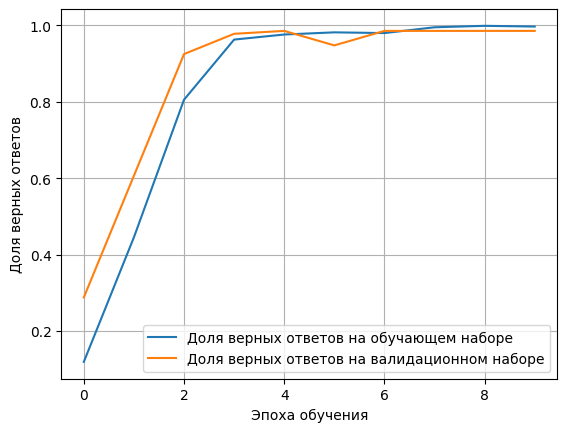

In [20]:
plot_accuracy_curve(cnn_model)

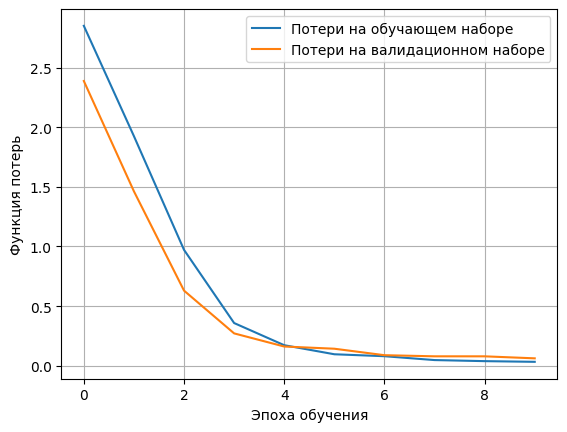

In [21]:
plot_loss_curve(cnn_model)

# Проверка качества модели

Загрузим отложенную выборку, чтобы проверить качество обученной модели.

In [22]:
with open('/kaggle/input/symbols-on-russian-license-plates-test-data/X_test.pickle', 'rb') as f:
    X_test_org = pickle.load(f)
    
with open('/kaggle/input/symbols-on-russian-license-plates-test-data/Y_test.pickle', 'rb') as f:
    Y_test_org = pickle.load(f)

Выполним все необходимые преобразования, прежде чем дать на вход модели наши тестовые данные.

In [23]:
X_test = np.expand_dims(X_test_org, axis=3)

In [24]:
Y_test = mapping_function(Y_test_org)

Создадим функцию для визуализации матрицы ошибок.

In [25]:
def evaluate_model(model):
    # Получение предсказаний для тестового набора данных
    Y_test_pred = model.predict(X_test, verbose=0)
    
    # Получение индекса класса с максимальной вероятностью
    Y_test_pred = np.argmax(Y_test_pred, axis=1)
    
    # Создание тепловой карты матрицы ошибок
    plt.figure(figsize=(10, 10))
    sns.heatmap(confusion_matrix(Y_test_pred, Y_test),
                annot=True, cmap='viridis', cbar=False)
    
    # Добавление подписей к тепловой карте
    plt.xlabel('Предсказанные метки')
    plt.ylabel('Истинные метки')
    
    # Оценка точности модели на тестовых данных
    accuracy = accuracy_score(Y_test, Y_test_pred)
    print(f'Точность модели: {accuracy * 100:.2f}%')
    
    # Оценка F1-меры модели на тестовых данных
    f1 = f1_score(Y_test, Y_test_pred, average='micro')
    print(f'F1-мера модели: {np.round(f1, 3)}')

Точность модели: 95.45%
F1-мера модели: 0.955


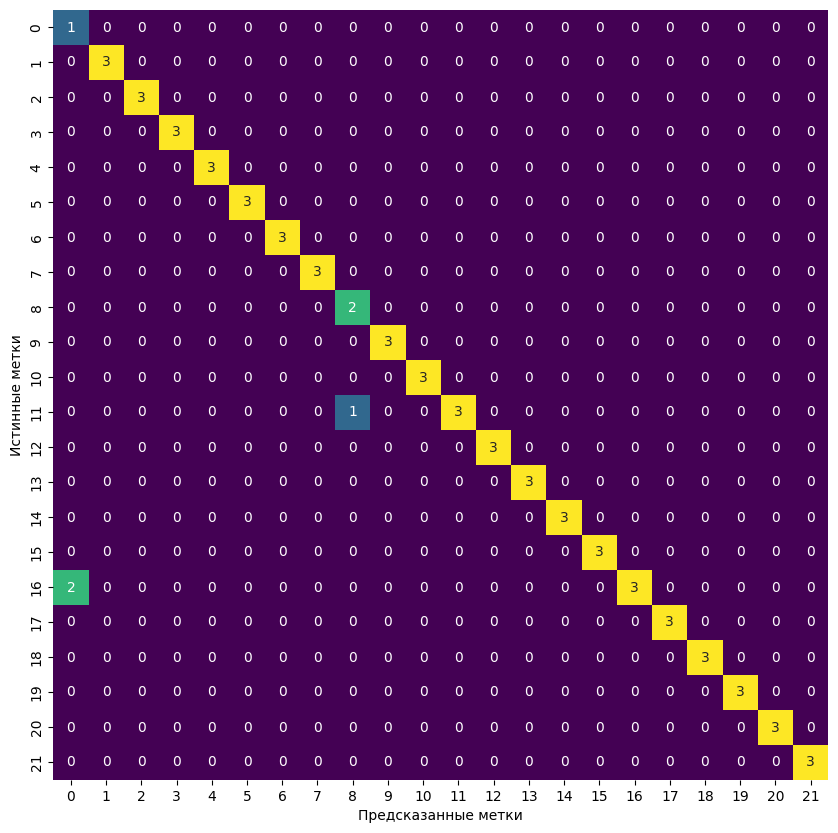

In [26]:
evaluate_model(model)